In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

from matplotlib.animation import FuncAnimation

from numba import njit
from tqdm import tqdm

In [2]:
@njit
def lj_acc(rij):
    a=0                                # Computing the acceleration for each _pair_ of particles  
    rij = pbc_distance(rij)            #Using the Lenard-Jones potential to write formula for acceleration
    d = 1/np.sqrt(sum(rij**2))
    return 48*(d**14 - 0.5*d**8)*rij
    # <===== Q 3(b) Fill this in

@njit
def lj_acc1(rij, r_c):
    a=0                                # Computing the acceleration for each pair of particles
    rij = pbc_distance(rij)            #Using the modifed Lenard-Jones potential to write formula for acceleration
    d = 1/np.sqrt(sum(rij**2))         #in order to take care of the discontinuity 
    d_cutoff = 1/r_c
    return 48*(d**14 - 0.5*d**8)*rij - 48*(d_cutoff**14 - 0.5*d_cutoff**8)*r_c
    # <===== Q 3(b) Fill this in


@njit
def get_pe(step_pos,r_c,L):# Calculating the potential energy using the modified Lennard-Jones potential
    
    potential = 0
     
    for p in range(N-1):                                               
            for q in range(p+1,N):
                rpq = step_pos[p] - step_pos[q]                #Using the Lenard-Jones Potential 
                rij = pbc_distance(rpq)
                dist = 1/np.sqrt(sum(rij**2))
                d_cutoff = 1/np.sqrt(r_c**2)
                potential = potential + 4*((dist)**12 - (dist)**6) - 4*((d_cutoff)**12 - (d_cutoff)**6) -  48*(d_cutoff**14 - 0.5*d_cutoff**8)*r_c*(np.sqrt(sum(rij**2))-r_c) 
    # Addig the extra correction terms to care of the discontinuity introduced due to the cutoff radius
    return potential

@njit
def get_ke(step_vel):#Calculating kinetik energy               
    kinetic = 0
    for m in range(N):                                 
        vel = step_vel[m]
        velocity = np.sqrt(sum(vel**2))
        kinetic = kinetic + 0.5*velocity**2
    return kinetic 


@njit
def pbc_distance(rij): #The corrected distance betwwen particles after implementing periodic boudary conditions 
    if np.abs(rij[0]) > 0.5*L:
            rij[0] = rij[0] - L*(rij[0]/ np.abs(rij[0]))   #Due to PBCs there are two possible values of distace, 
    if np.abs(rij[1]) > 0.5*L:                             #taking the smaller one out of those  
            rij[1] = rij[1] - L*(rij[1]/ np.abs(rij[1]))    
    return rij

@njit
def computeNeighbourList(r_cutoff, pos):#Keeping track of the neighbours at a timestep
    cumulativeNeighbours = np.zeros((N, N))#Cumulative list of the neighbour list of all particles 
    #r=np.array([0.])
    for i in range(N):
        numberInList = np.zeros(N) #starting with zeros
        for j in range(N):
            rn=pbc_distance(pos[j]-pos[i])
            r1=np.sqrt(rn[0]**2+rn[1]**2)
            #r=np.append(r,r1)
            if r1 < r_cutoff:
                if j == i:
                    numberInList[j] = 0 #the element for the particle ittself is always zero
                else:
                    numberInList[j] =+ 1 #If the particle is within the cutoff, making the corresponding element 1
        cumulativeNeighbours[i] = numberInList #list of all lists
    return cumulativeNeighbours


@njit
def maxwell(v,T):
    p = (1./T)*v*np.exp(-0.5*v*v/T)
    return p

In [3]:
def init_pos(Lx, Ly, Nx, Ny):

    N = Nx*Ny                                       # Total number of particles in the lattice
    
    dx = Lx/Nx                                      # Spacing between particles along the  
    dy = Ly/Ny                                      # x and y axes
    
    ipos = np.zeros((N,2))                          # Empty array to store positions

    n=0                                             # Counter to count the number of particles
    
    for x in range(Nx):                             # Loop over all particles
        for y in range(Ny):
            ipos[n] = [dx/2 + dx*x, dy/2 + dy*y]    # Assign positions to each particle
            n+=1                                    # Increment counter
    
    return ipos


def init_vel(N):
    ivel = np.zeros((N,2), dtype=np.float32)         # Initialise the empty array for velocities 

    T = 2.5                                         # Initial "temperature" of the system
    T0 = 1                                           # Temperature scale of the problem

    v0 = np.sqrt(2*T/T0)                             # Initial speed of each particle

    for i in range(N):                               # Loop over each particle and 
        r = 2*np.pi*np.random.random()               # assign it a random direction
        ivel[i][0] = v0 * np.cos(r)                  # Set the x and y components of the velocity
        ivel[i][1] = v0 * np.sin(r)                  # while keeping the magnitude constant

    vcm = np.sum(ivel,axis=0)/N                      # Compute the centre of mass velocity
    ivel = ivel-vcm                                  # Subtract the COM velocity so the COM is stationary

    return ivel


In [8]:
@njit
def simulate(ipos, ivel, nu, T, r_c,tf=100, dt=0.01):
    
    n_steps = int(tf/dt)                                     # Number of simulation steps

    pos = np.zeros(shape=(n_steps,N,2), dtype=np.float32)    # Arrays to store the history of the particles'
    vel = np.zeros(shape=(n_steps,N,2), dtype=np.float32)    # positions and velocities

    KE = np.zeros(n_steps)                                   # Arrays to store the history of the particles'
    PE = np.zeros(n_steps)                                   # kinetic and potential energies
    #P = np.zeros((n_steps,N-1))  
    pos[0] = ipos                                            # Setting initial positions to `ipos`
    vel[0] = ivel                                            # Setting initial velocities to `ivel`

    KE[0] = get_ke(vel[0])                                   # Computing initial kinetic and potential
    PE[0] = get_pe(pos[0],2.3,L=L)                              # energies
    

    for s in range(1,n_steps-1):
        pos[s] = pos[s - 1] + dt/2 * vel[s - 1] # Velrelt half-step
        
        for m in range(N): #Imposing periodic boundary conditions. 
            if pos[s][m][0] >= L:
                pos[s][m][0] = pos[s][m][0] - L
            if pos[s][m][0] <= 0:
                pos[s][m][0] = pos[s][m][0] + L
            if pos[s][m][1] >= L:
                pos[s][m][1] = pos[s][m][1] - L
            if pos[s][m][1] <= 0:
                pos[s][m][1] = pos[s][m][1] + L

        net_a = np.zeros((N,2), dtype=np.float32)            # Empty array to store the net acceleration of each particle

        for p in range(N-1): # Computing the acceleration for each pair of particles              
            for q in range(p+1,N):
                
                acc = lj_acc(pos[s][p] - pos[s][q]) # acc = <==== Compute the acceleration between pairs of particles
                #P[s][p] = pbc_distance(pos[s][p] - pos[s][q])[0]*acc[0] + pbc_distance(pos[s][p] - pos[s][q])[1]*acc[1]
                    
                net_a[p] += acc                              # Use the third-law to impart equal and opposite 
                net_a[q] -= acc                              # accelerations to each particle


        vel[s] = vel[s - 1] + dt * net_a  #Verlet full step
        pos[s] = pos[s] + dt/2 * vel[s]
                
    
        for m in range(N): #Re-imposing periodic boundary conditions. 
            if pos[s][m][0] >= L:
                pos[s][m][0] = pos[s][m][0] - L
            if pos[s][m][0] <= 0:
                pos[s][m][0] = pos[s][m][0] + L
            if pos[s][m][1] >= L:
                pos[s][m][1] = pos[s][m][1] - L
            if pos[s][m][1] <= 0:
                pos[s][m][1] = pos[s][m][1] + L
                
        #Andersen Thermostat         

        for b in range(N):
            r = np.random.uniform(0,1)
            if r <= nu*dt: #picking a particle with the specified probability
                r1 = np.random.uniform(0,1)
                r2 = np.random.uniform(0,1)*2*np.pi
                vel[s][b][0] = np.sqrt(-2*T*np.log(r1))*np.cos(r2) #Assigning velocitied drawn from the maxwell-Boltzmann
                vel[s][b][1] = np.sqrt(-2*T*np.log(r1))*np.sin(r2) #Distribution                
                
        KE[s] = get_ke(vel[s])                               # Compute the kinetic and potential energies at 
        PE[s] = get_pe(pos[s],2.3,L=L)                       # the current step
        
    return pos, vel, KE, PE
        

In [5]:
@njit
def newsimulate(ipos, ivel, nu, T,r_c,r_n,tf=99, dt=0.01):
    
    n_steps = int(tf/dt)                                     # Number of simulation steps

    pos = np.zeros(shape=(n_steps,N,2), dtype=np.float32)    # Arrays to store the history of the particles'
    vel = np.zeros(shape=(n_steps,N,2), dtype=np.float32)    # positions and velocities

    KE = np.zeros(n_steps)                                   # Arrays to store the history of the particles'
    PE = np.zeros(n_steps)                                   # kinetic and potential energies
    #P = np.zeros((n_steps,N-1))  
    pos[0] = ipos                                            # Setting initial positions to `ipos`
    vel[0] = ivel                                            # Setting initial velocities to `ivel`
    
    pnn=np.zeros(shape=(int(10000/15),N,N))                  #Array to keep track of all the neigbour lists calculated for
                                                             #every 15th timestep.   

    KE[0] = get_ke(vel[0])                                   # Computing initial kinetic and potential
    PE[0] = get_pe(pos[0], 2.3,L=L)                              # energies
    

    for s in range(1,n_steps-1): 
    
        pos[s] = pos[s - 1] + dt/2 * vel[s - 1]  # Velrelt half-step
                
        for m in range(N):  #Imposing periodic boundary conditions. 
            if pos[s][m][0] >= L:
                pos[s][m][0] = pos[s][m][0] - L
            if pos[s][m][0] <= 0:
                pos[s][m][0] = pos[s][m][0] + L
            if pos[s][m][1] >= L:
                pos[s][m][1] = pos[s][m][1] - L
            if pos[s][m][1] <= 0:
                pos[s][m][1] = pos[s][m][1] + L

        if s%15==0: #For every 15th timestep, updating the neighbou lists for all particles and storin them
            pnn[int(s/15)]=computeNeighbourList(r_c,pos[s])

        net_a = np.zeros((N,2), dtype=np.float32)            # Empty array to store the net acceleration of each particle

        for p in range(N-1):                                           
            for q in range(p+1,N):
                if pnn[int(s/15)][p][q]==1: #Computing the acceleration between the particles only if they are in the 
                    acc = lj_acc1(pos[s][p] - pos[s][q], 2.3)#nighbour list of the paticle being looped over. 
                
                   # P[s][p] = pbc_distance(pos[s][p] - pos[s][q])[0]*acc[0] + pbc_distance(pos[s][p] - pos[s][q])[1]*acc[1]
                    
                    net_a[p] += acc                              # Use the third-law to impart equal and opposite 
                    net_a[q] -= acc                              # accelerations to each particle


        vel[s] = vel[s - 1] + dt * net_a  #Verlet full step
        pos[s] = pos[s] + dt/2 * vel[s]
                

        for m in range(N): #Re-imposing periodic boundary conditions. 
            if pos[s][m][0] >= L:
                pos[s][m][0] = pos[s][m][0] - L
            if pos[s][m][0] <= 0:
                pos[s][m][0] = pos[s][m][0] + L
            if pos[s][m][1] >= L:
                pos[s][m][1] = pos[s][m][1] - L
            if pos[s][m][1] <= 0:
                pos[s][m][1] = pos[s][m][1] + L
                
        #Andersen Thermostat              

        for b in range(N):
            r = np.random.uniform(0,1)
            if r <= nu*dt: #picking a particle with the specified probability
                r1 = np.random.uniform(0,1)
                r2 = np.random.uniform(0,1)*2*np.pi
                vel[s][b][0] = np.sqrt(-2*T*np.log(r1))*np.cos(r2) #Assigning velocitied drawn from the maxwell-Boltzmann
                vel[s][b][1] = np.sqrt(-2*T*np.log(r1))*np.sin(r2) #Distribution                 
                
        KE[s] = get_ke(vel[s])                               # Compute the kinetic and potential energies at 
        PE[s] = get_pe(pos[s], 2.3,L=L)                      # the current step
        
    return pos, vel, KE, PE
        

In [4]:
Nx = 11                # Number of particles per row initially along x
Ny = 11                # Number of particles per row iniailly along y
N = Nx*Ny                # Total number of particles
rho = 0.5                # Density of the system
L = np.sqrt(N/rho)       # Length of the system

ipos = init_pos(Lx=L, Ly=L, Nx=Nx, Ny=Ny)  # Initial positions (square grid)
ivel = init_vel(N)                         # Initial velocities 


tf = 100
dt = 0.01
time = np.arange(0,int(tf/dt))*dt

In [9]:
%%time 
pos1,vel1, KE1, PE1 = simulate(ipos, ivel, 0.1, 0.5, 2.3,100, dt=dt)

CPU times: total: 33.4 s
Wall time: 1min 10s


In [7]:
%%time 
posi, veli, KEi, PEi=newsimulate(ipos, ivel, 0.1, 0.5,2.3,2.7, tf=99, dt=0.01)

CPU times: total: 13.7 s
Wall time: 24.8 s


In [31]:
lattice = np.array([9,10,11, 12,14,15,16])
sim = np.array([16.6, 21.5,33.4,43.5,90,119,137])
newsim = np.array([5.7,11, 12.4, 13.2,22.7,42.1,62])

In [32]:
m1, c1 = np.polyfit(np.log(lattice**2), np.log(sim),1)
m2 ,c2 = np.polyfit(np.log(lattice**2), np.log(newsim),1)
print(m1,c1)#slope and intercept for the linear fit for the simulate funcyion
print(m2,c2)#slope and intercept for the linear fit for the newsimulate funcyion

1.9420642982161398 -5.803361121410923
1.8587221028375112 -6.405433012503051


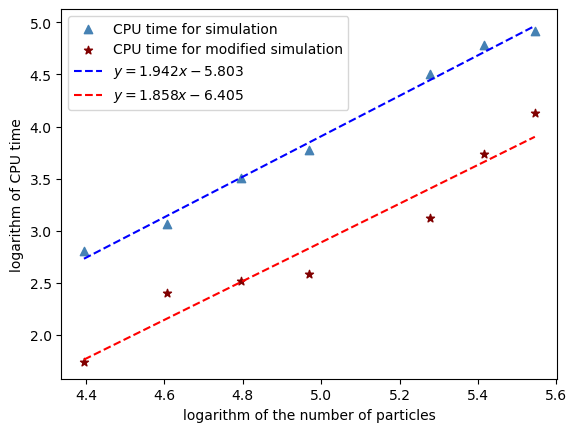

In [38]:
plt.scatter(np.log(lattice**2), np.log(sim), marker = '^',color = 'steelblue', label='CPU time for simulation')
plt.scatter(np.log(lattice**2), np.log(newsim),marker= '*',color = 'maroon', label='CPU time for modified simulation')
plt.plot(np.log(lattice**2), m1*np.log(lattice**2) + c1,linestyle = '--',color = 'blue', label = r'$y = 1.942 x - 5.803 $')
plt.plot(np.log(lattice**2), m2*np.log(lattice**2) + c2,linestyle = '--',color = 'red', label = r'$y = 1.858 x - 6.405$')
plt.xlabel('logarithm of the number of particles')
plt.ylabel('logarithm of CPU time')
plt.legend()

In [32]:
%%time
 
pos1,vel1, KE1, PE1 = simulate(ipos, ivel, 0.1, 0.5, 2.3,100, dt=dt)
pos2,vel2, KE2, PE2 = simulate(ipos, ivel, 0.1, 2, 2.3,100, dt=dt)
# pos3,vel3, KE3, PE3 = simulate(ipos, ivel, 0.1, 2.5, 2.3,100, dt=dt)
pos4,vel4, KE4, PE4 = simulate(ipos, ivel, 0.5, 0.1, 2.3,100, dt=dt)
# pos5,vel5, KE5, PE5 = simulate(ipos, ivel, 0.7, 0.05, 2.3,100, dt=dt)

CPU times: total: 27.2 s
Wall time: 42.3 s


In [37]:
#pos2,vel2, KE2, PE2 = simulate(ipos, ivel, 0.1, 2, 2.3,100, dt=dt)

In [36]:
pos4,vel4, KE4, PE4 = simulate(ipos, ivel, 0.5, 0.1, 2.3,100, dt=dt)
pos4,vel4, KE4, PE4 = simulate(ipos, ivel, 0.5, 0.1, 2.3,100, dt=dt)

In [33]:
@njit
def compute_RDF(dr,s,posa):
    # accumulate data for n(r)
    L1=((L)**2+(L)**2)**0.5 #largest possible distance between two particles
    g= L1/dr #number of bins
    r=np.array([0.]) #array to store the separations
#     r_count=np.zeros(shape=(N-1,int(g)))
    for i in range(N - 1):
         for j in range(i + 1, N):
                rn=pbc_distance(posa[s][j]-posa[s][i])
                r1=np.sqrt(rn[0]**2+rn[1]**2) #Getting the separation between a pair of particles
                r=np.append(r,r1) #storing it in an array
    r = r[0:]
    hist, binedges = np.histogram(r, int(g))#dividing the values of separation in bins of thickness dr
    return hist, binedges

Text(0.5, 0, 'r')

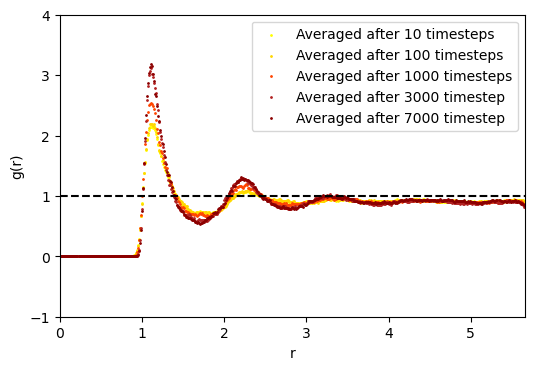

In [81]:
plt.scatter(mid6, gaverage6,s=1,color = 'yellow', label='Averaged after 10 timesteps')
plt.scatter(mid3, gaverage3,s=1,color = 'gold', label='Averaged after 100 timesteps')
plt.scatter(mid2, gaverage2,s=1,color = 'orangered', label='Averaged after 1000 timesteps')
plt.scatter(mid1, gaverage1,s=1,color = 'firebrick', label='Averaged after 3000 timestep')
plt.scatter(mid5, gaverage5,s=1,color = 'darkred', label='Averaged after 7000 timestep')
#plt.scatter(mid4, gaverage4,s=1,color = 'yellow', label='T = 0.5')
plt.axhline(1, linestyle = '--', color = 'black')
plt.xlim(xmin = 0,xmax = L/2)
plt.ylim(ymin = -1,ymax = 4)
plt.legend()
plt.ylabel('g(r)')
plt.xlabel('r')

In [38]:
# %%time

L1=((L)**2+(L)**2)**0.5
g= L1/0.025

compMid1= np.zeros(2999)
compNormG1= np.zeros(2999)
compnormGf1=np.zeros((2999,int(g)))
for ts in range(7000, 9999):
    abc,efg=compute_RDF(0.025,ts,pos1)


    mid1 = np.zeros(len(efg)-1)
    normG1 = np.zeros(len(efg)-1)
    for i in range(len(efg)-1):
        mid1[i] = (efg[i+1]+efg[i])/2 #radius corresponding to the bin
        normG1[i] = abc[i]/(2*np.pi*mid1[i]) #normalisation factor
        compnormGf1[ts-7000][i]=normG1[i]

gaverage1 = (np.sum(compnormGf1, axis = 0))/(len(efg)-1)#Array of RDF after normalisation averaging over 2999 timesteps


compMid2= np.zeros(2999)
compNormG2= np.zeros(2999)
compnormGf2=np.zeros((2999,int(g)))
for ts in range(7000, 9999):
    abc,efg=compute_RDF(0.025,ts,pos2)
# # plt.show()

    mid2 = np.zeros(len(efg)-1)
    normG2 = np.zeros(len(efg)-1)
    for i in range(len(efg)-1):
        mid2[i] = (efg[i+1]+efg[i])/2
        normG2[i] = abc[i]/(2*np.pi*mid2[i])
        compnormGf2[ts-7000][i]=normG2[i]

gaverage2 = (np.sum(compnormGf2, axis = 0))/(len(efg)-1)



compMid4= np.zeros(2999)
compNormG4= np.zeros(2999)
compnormGf4=np.zeros((2999,int(g)))

for ts in range(7000, 9999):
    abc,efg=compute_RDF(0.025,ts,pos4)

    mid4 = np.zeros(len(efg)-1)
    normG4 = np.zeros(len(efg)-1)
    for i in range(len(efg)-1):
        mid4[i] = (efg[i+1]+efg[i])/2
        normG4[i] = abc[i]/(2*np.pi*mid4[i])
        compnormGf4[ts-7000][i]=normG4[i]

gaverage4 = (np.sum(compnormGf4, axis = 0))/(len(efg)-1)

Text(0.5, 0, 'r')

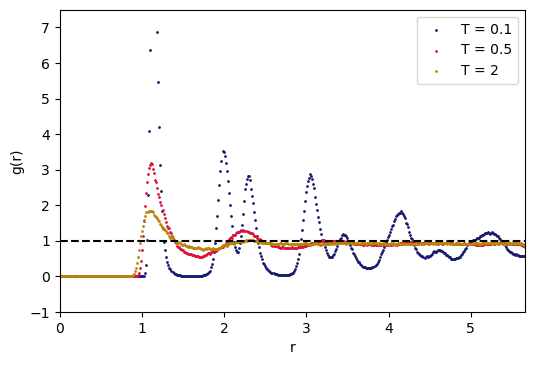

In [46]:
#plt.scatter(mid5, gaverage5,s=1,color = 'midnightblue', label ='T = 0.05')
plt.scatter(mid4, gaverage4,s=1,color = 'midnightblue', label='T = 0.1')
plt.scatter(mid1, gaverage1,s=1,color = 'crimson', label='T = 0.5')
plt.scatter(mid2, gaverage2,s=1,color = 'darkgoldenrod', label='T = 2')
#plt.scatter(mid3, gaverage3,s=1,color = 'darkgoldenrod', label='T = 2.5')
plt.axhline(1, linestyle = '--', color = 'black')
plt.xlim(xmin = 0,xmax = L/2)
plt.ylim(ymin = -1,ymax = 7.5)
plt.legend()
plt.ylabel('g(r)')
plt.xlabel('r')

In [39]:
print(np.sum(gaverage1*2*np.pi*mid1*0.025)*0.5)

In [31]:
def retu(dr,s,pos,vel,KE,PE): #getting the potential energy from the RDF
    
    out3,out4=compute_RDF(dr,s,pos)
    
#     ar=np.zeros(len(out1))
#     hn1=np.zeros(160)
    V=L**2
    T=np.sum(KE[s])/N
    l1=np.zeros(160)
    U1=np.zeros(160)
    gave1=np.zeros(160)
    
    for i in range(40,200):
        
#         l1[i-40]=(out4[i]+out4[i+1])/2
#         gave1[i-40]=out3[i]/(np.pi*l1[i-40]*dr)
        r=dr*i
        u=4*(r**-12-r**-6) #PE as a funtion of separation
        U1[i-40]=u
    hn=U1*gaverage[40:200] #pre-integral of PE per particle
    uf=np.sum(hn)*64
    
    return uf# PE fraom RDF


In [90]:
def retp(dr,r_c,s,pos,vel,KE,PE):#getting the pressure from the RDF

    out1,out2=compute_RDF(dr,s,pos)

#     ar=np.zeros(len(out1))
    ar=np.zeros(shape=(len(out1)))
    hn=np.zeros(shape=(len(out1)))
    V=L**2
    T=np.sum(KE[s])/N#instantaneous temperature
    l=np.zeros(len(out1))
    gave=np.zeros(len(out1))

    for i in range(1,len(out1)):

        l[i]=(out2[i]+out2[i+1])/2
        gave[i]=out1[i]/(2*np.pi*l[i]*dr)
        r=dr*i
        a=np.sqrt(lj_acc1(np.array([r/(2**0.5),r/(2**0.5)]),r_c)[0]**2+lj_acc1(np.array([r/(2**0.5),r/(2**0.5)]),r_c)[1]**2)#Magnitude of modified acceleration
        ar[i]=a*out1[i]
        hn[i]=(gave[i]*r*ar[i]*dr)
    ar=ar[50:200]#beyond this point the results of the RDF calculation seem to become unreliable. Suspected to be something to do with PBCs
    hn=hn[50:200]#pre-integral of pressure

    p=N*T*(1-np.sum(hn)/(4*T))/(L**2) #pressure

    return T, p
#PV/nkt = 1 - rho/4kT(integral(g(r)(rljacc1)dr)

In [100]:
press = np.array([0.])
for Ts in np.array([0.5,0.75,1,1.25,1.5,2,2.5]):
    p, v, ke, pe = simulate(ipos, ivel, 0.1, Ts, 100, dt=dt)
    pres = retp(0.025,2.3,9998,p,v,ke,pe)[0]
    press = np.append(press, pres)

0.5502085116436829 -0.04955796798178195


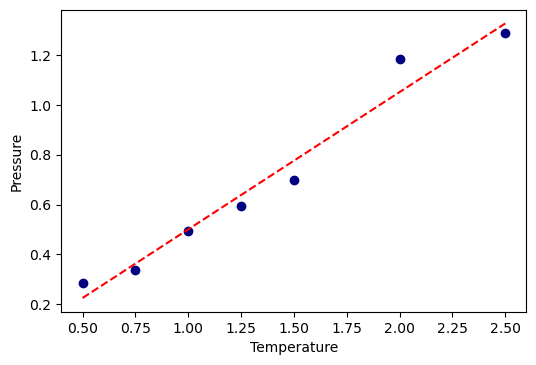

In [109]:
plt.scatter(np.array([0.5,0.75,1,1.25,1.5,2,2.5]), press/2, color = 'navy')
m, c = np.polyfit(np.array([0.5,0.75,1,1.25,1.5,2,2.5]), press/2,1)
plt.plot(np.array([0.5,0.75,1,1.25,1.5,2,2.5]), m*np.array([0.5,0.75,1,1.25,1.5,2,2.5]) + c, linestyle = '--',color = 'red')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
print(m,c)

In [32]:
retu(0.025,9998,pos,vel,KE,PE)# Value of PE from RDF at a particular timstep 

-120.25181158353976

In [33]:
#cell 18
usher=0
for i in range(8000,9998):
    ur=retu(0.025,i,pos,vel,KE,PE)
    usher+=ur/1998
    
print(usher)# Value of PE from RDF averaged over the last 1998 timsteps

-120.251811583536


In [36]:
np.mean(PE[8000:9998]) #VAlue of PE from the simulate function

-107.34073810803092

In [70]:
print(np.sum(gaverage3))

69.89486780698488
